### note: Python version 3

In [1]:
# import elasticsearch ### pip install elasticsearch=="1.4.0"
import pyes ### pip install pyes=="0.99.4"
import json
import pandas as pd

conn = pyes.ES('127.0.0.1:9200') ### only exec once

## print a, b 的 query

In [2]:
bq = pyes.query.BoolQuery()

keywords = \
'CVE Vulnerability Exploit Forensic Steganography Webshell Cipher Patch Overflow SSL'
mq = pyes.query.MatchQuery(field= "text", text= keywords)
bq.add_must(mq)

ESR = pyes.ESRange(field= 'created_at',
                   from_value= 'Wed Jan 01 00:00:00 +0000 2014', to_value= 'Thu Jan 01 00:00:00 +0000 2015',
                   include_lower= True, include_upper= False) ### equals "gte": "XXX", "lt": "XXX"
rq = pyes.query.RangeQuery(qrange= ESR)
bq.add_must(rq)

tagg = pyes.aggs.TermsAgg('users_id', field= 'uid', size= 0) ### "size" 0 for showing all result

qsearch = pyes.query.Search(bq, size= 0) ### "size" 0 for "hits" not showing
qsearch.agg.add(tagg)

result = conn.search(query= qsearch, indices= 'twitter2', doc_types= 'tweet')

### for printing es query
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

replace_dict = {"'": '"', 'True': 'true', 'False': 'false'}
print (replace_all(str(qsearch), replace_dict))

{"query": {"bool": {"must": [{"match": {"text": {"query": "CVE Vulnerability Exploit Forensic Steganography Webshell Cipher Patch Overflow SSL", "type": "boolean", "operator": "or"}}}, {"range": {"created_at": {"include_upper": false, "include_lower": true, "to": "Thu Jan 01 00:00:00 +0000 2015", "from": "Wed Jan 01 00:00:00 +0000 2014"}}}]}}, "size": 0, "aggs": {"users_id": {"terms": {"field": "uid", "size": 0}}}}


In [3]:
print ('a. 共計有 ' + str(len(result.aggs['users_id']['buckets'])) + ' 位Twitter參與這類關鍵字議題討論')
print ('b. 共計有 ' + str(result.count()) + ' 個Tweets')

a. 共計有 96 位Twitter參與這類關鍵字議題討論
b. 共計有 2452 個Tweets


## print c, d 的 query (用 pyes 包好的 query)

In [4]:
### pyes doesn't support "DateHistogramAgg format", "min_doc_count" 0 for showing 0 tweet in month
dhagg = pyes.aggs.DateHistogramAgg('tweets_in_month', field= 'created_at', interval= 'month', min_doc_count= 0,
                                   sub_aggs= [])
dhagg_sub = pyes.aggs.TermsAgg('twitters_in_month', field= 'uid')
dhagg.sub_aggs.append(dhagg_sub)
qsearch.agg.reset() ### reset for clear
qsearch.agg.add(dhagg)
result = conn.search(query= qsearch, indices= 'twitter2', doc_types= 'tweet')

print (replace_all(str(qsearch), replace_dict))

{"query": {"bool": {"must": [{"match": {"text": {"query": "CVE Vulnerability Exploit Forensic Steganography Webshell Cipher Patch Overflow SSL", "type": "boolean", "operator": "or"}}}, {"range": {"created_at": {"include_upper": false, "include_lower": true, "to": "Thu Jan 01 00:00:00 +0000 2015", "from": "Wed Jan 01 00:00:00 +0000 2014"}}}]}}, "size": 0, "aggs": {"tweets_in_month": {"aggs": {"twitters_in_month": {"terms": {"field": "uid", "size": 100}}}, "date_histogram": {"field": "created_at", "interval": "month", "min_doc_count": 0}}}}


## c, d 的 query (用 search_raw)

In [5]:
### 這邊我使用raw query來做到pyes沒提供的function，以方便之後的操作
raw_query =\
{
  "size": 0,
  "query": {
    "bool": {
      "must": [
        {
          "match": {
            "text": {
              "type": "boolean",
              "query": "CVE Vulnerability Exploit Forensic Steganography Webshell Cipher Patch Overflow SSL",
              "operator": "or"
            }
          }
        },
        {
          "range": {
            "created_at": {
              "gte": "Wed Jan 01 00:00:00 +0000 2014",
              "lt": "Thu Jan 01 00:00:00 +0000 2015"
            }
          }
        }
      ]
    }
  },
  "aggs": {
    "tweets_in_month": {
      "aggs": {
        "twitters_in_month": {
          "terms": {
            "size": 100,
            "field": "uid"
          }
        }
      },
      "date_histogram": {
        "interval": "month",
        "field": "created_at",
        "min_doc_count": 0,
        "format": "yyyy-MM"
      }
    }
  }
}
result_raw_query = conn.search_raw(query= raw_query, indices= 'twitter2', doc_types= 'tweet')

### c 的 pandas DataFrame (用 pyes 包好的 query)

In [6]:
print ('c 的 pandas DataFrame (用 pyes 包好的 query)')

twitters_in_month = []
for this_month in result.aggs['tweets_in_month']['buckets']:
    dic = {}
    dic['Month'] = this_month['key_as_string']
    dic['Count'] = len(this_month['twitters_in_month']['buckets'])
    twitters_in_month.append(dic)

### convert to "pandas DataFrame" for showing
pd_dataframe = pd.DataFrame(twitters_in_month)
pd_dataframe

c 的 pandas DataFrame (用 pyes 包好的 query)


,Count,Month
0,35,Wed Jan 01 00:00:00 +0000 2014
1,45,Sat Feb 01 00:00:00 +0000 2014
2,37,Sat Mar 01 00:00:00 +0000 2014
3,59,Tue Apr 01 00:00:00 +0000 2014
4,48,Thu May 01 00:00:00 +0000 2014
5,48,Sun Jun 01 00:00:00 +0000 2014
6,49,Tue Jul 01 00:00:00 +0000 2014
7,50,Fri Aug 01 00:00:00 +0000 2014
8,66,Mon Sep 01 00:00:00 +0000 2014
9,67,Wed Oct 01 00:00:00 +0000 2014


### c 的 pandas DataFrame (用 search_raw)

In [7]:
print ('c 的 pandas DataFrame (用 search_raw)')

twitters_in_month = []
for this_month in result_raw_query['aggregations']['tweets_in_month']['buckets']:
    dic = {}
    dic['Month'] = this_month['key_as_string']
    dic['Count'] = len(this_month['twitters_in_month']['buckets'])
    twitters_in_month.append(dic)

### convert to "pandas DataFrame" for showing
pd_dataframe = pd.DataFrame(twitters_in_month)
pd_dataframe

c 的 pandas DataFrame (用 search_raw)


,Count,Month
0,35,2014-01
1,45,2014-02
2,37,2014-03
3,59,2014-04
4,48,2014-05
5,48,2014-06
6,49,2014-07
7,50,2014-08
8,66,2014-09
9,67,2014-10


### d 的 pandas DataFrame (用 pyes 包好的 query)

In [8]:
print ('d 的 pandas DataFrame (用 pyes 包好的 query)')

tweets_in_month = []
for tweet in result.aggs['tweets_in_month']['buckets']:
    dic = {}
    dic['Month'] = tweet['key_as_string']
    dic['Count'] = tweet['doc_count']
    tweets_in_month.append(dic)

### convert to "pandas DataFrame" for showing
pd_dataframe = pd.DataFrame(tweets_in_month)
pd_dataframe

d 的 pandas DataFrame (用 pyes 包好的 query)


,Count,Month
0,143,Wed Jan 01 00:00:00 +0000 2014
1,236,Sat Feb 01 00:00:00 +0000 2014
2,138,Sat Mar 01 00:00:00 +0000 2014
3,271,Tue Apr 01 00:00:00 +0000 2014
4,164,Thu May 01 00:00:00 +0000 2014
5,187,Sun Jun 01 00:00:00 +0000 2014
6,180,Tue Jul 01 00:00:00 +0000 2014
7,126,Fri Aug 01 00:00:00 +0000 2014
8,280,Mon Sep 01 00:00:00 +0000 2014
9,303,Wed Oct 01 00:00:00 +0000 2014


### d 的 pandas DataFrame (用 search_raw)

In [9]:
print ('d 的 pandas DataFrame (用 search_raw)')

tweets_in_month = []
for tweet in result_raw_query['aggregations']['tweets_in_month']['buckets']:
    dic = {}
    dic['Month'] = tweet['key_as_string']
    dic['Count'] = tweet['doc_count']
    tweets_in_month.append(dic)

### convert to "pandas DataFrame" for showing to compare last query result
pd_dataframe = pd.DataFrame(tweets_in_month)
pd_dataframe

d 的 pandas DataFrame (用 search_raw)


,Count,Month
0,143,2014-01
1,236,2014-02
2,138,2014-03
3,271,2014-04
4,164,2014-05
5,187,2014-06
6,180,2014-07
7,126,2014-08
8,280,2014-09
9,303,2014-10


In [10]:
import matplotlib.pyplot as plt
### coding:utf-8
plt.rcParams['font.sans-serif'] = ['SimHei'] ### 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False ### 用来正常显示负号
### 有中文出现的情况，需要u'内容'，python3不需要

### c. 每個月參與的Twitter數量長條圖 by matplotlib

c. 每個月參與的Twitter數量長條圖 by matplotlib


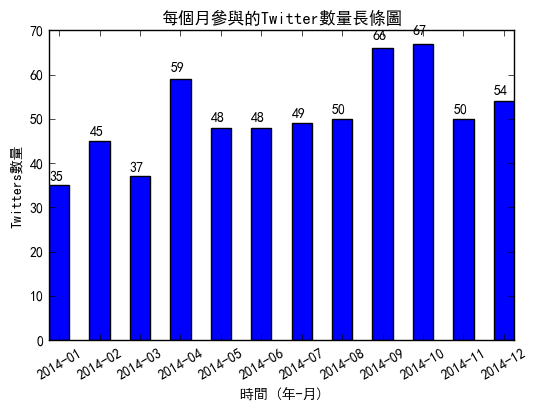

In [11]:
print ('c. 每個月參與的Twitter數量長條圖 by matplotlib')

left_bar = []
height_bar = []
xtick = []
width = 1
i = 0
for row_dict in twitters_in_month:
    left_bar.append(i)
    i += width*2
    height_bar.append(row_dict['Count'])
    xtick.append(row_dict['Month'])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x(), 1.03*height, '%s' % int(height))

plt.title('每個月參與的Twitter數量長條圖')
plt.xlabel('時間 (年-月)')
plt.ylabel('Twitters數量')
plt.xticks(left_bar, xtick)

rect = plt.bar(left= left_bar, height= height_bar, width= width, align= 'center')
autolabel(rect)
plt.setp(plt.xticks()[1], rotation= 30)
plt.show()

### d. 每個月參與Tweets數量長條圖 by matplotlib

d. 每個月參與Tweets數量長條圖 by matplotlib


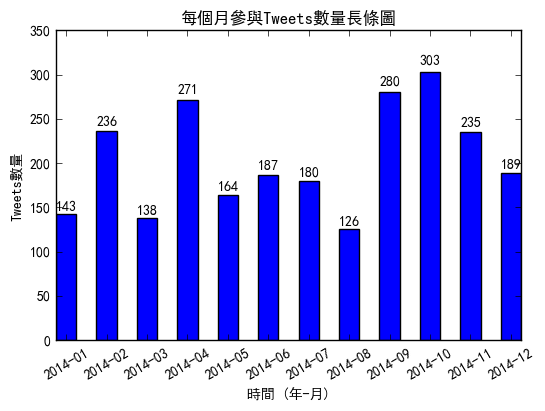

In [12]:
print ('d. 每個月參與Tweets數量長條圖 by matplotlib')

left_bar = []
height_bar = []
xtick = []
width = 1
i = 0
for row_dict in tweets_in_month:
    left_bar.append(i)
    i += width*2
    height_bar.append(row_dict['Count'])
    xtick.append(row_dict['Month'])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x(), 1.03*height, '%s' % int(height))

plt.title('每個月參與Tweets數量長條圖')
plt.xlabel('時間 (年-月)')
plt.ylabel('Tweets數量')
plt.xticks(left_bar, xtick)

rect = plt.bar(left= left_bar, height= height_bar, width= width, align= 'center')
autolabel(rect)
plt.setp(plt.xticks()[1], rotation= 30)
plt.show()

In [13]:
from bokeh.charts import Bar, show
from bokeh.io import output_notebook

### c. 每個月參與的Twitter數量長條圖 by bokeh

In [14]:
print ('c. 每個月參與的Twitter數量長條圖 by bokeh')

output_notebook()
show(Bar(twitters_in_month, values= 'Count', label= 'Month',
         title= '每個月參與的Twitter數量長條圖', legend= False, plot_width= 500))

c. 每個月參與的Twitter數量長條圖 by bokeh


Loading BokehJS ...

### d. 每個月參與Tweets數量長條圖 by bokeh

In [15]:
print ('d. 每個月參與Tweets數量長條圖 by bokeh')

output_notebook()
show(Bar(tweets_in_month, values= 'Count', label= 'Month',
          title= '每個月參與Tweets數量長條圖', legend= False, plot_width= 500))

d. 每個月參與Tweets數量長條圖 by bokeh


Loading BokehJS ...

## e 的 query (用 search_raw)

In [16]:
### 這邊我使用raw query來做到pyes沒提供的function
raw_query =\
{
  "size": 0,
  "query": {
    "bool": {
      "must": [
        {
          "match": {
            "text": "CVE Vulnerability Exploit Forensic Steganography Webshell Cipher Patch Overflow SSL"
          }
        },
        {
          "range": {
            "created_at": {
              "gte": "Wed Jan 01 00:00:00 +0000 2014",
              "lt": "Thu Jan 01 00:00:00 +0000 2015"
            }
          }
        },
        {
          "regexp": {
            "text": "http[s]?"
          }
        }
      ]
    }
  }
}
result_raw_query = conn.search_raw(query= raw_query, indices= 'twitter2', doc_types= 'tweet')

## e 的 pandas DataFrame (用 search_raw)

In [17]:
print ('e 的 pandas DataFrame (用 search_raw)')

data_e = [{'type': '無URL %.2f%%' % ((result.count() - result_raw_query['hits']['total']) / result.count() * 100),
           'Count': result.count() - result_raw_query['hits']['total']},
          {'type': '有URL %.2f%%' % (result_raw_query['hits']['total'] / result.count() * 100),
           'Count': result_raw_query['hits']['total']}]

### convert to "pandas DataFrame" for showing to compare last query result
pd_dataframe = pd.DataFrame(data_e)
pd_dataframe

e 的 pandas DataFrame (用 search_raw)


,Count,type
0,516,無URL 21.04%
1,1936,有URL 78.96%


### e. 其中有URL與無URL的Tweets的比例圓餅圖

In [18]:
print ('e. 其中有URL與無URL的Tweets的比例圓餅圖')

from bokeh.charts import Donut ### "show" is already import

output_notebook()
show(Donut(pd_dataframe, label= ['type'], values= 'Count', text_font_size= '15pt',
           title= '其中有URL與無URL的Tweets的比例圓餅圖'))

e. 其中有URL與無URL的Tweets的比例圓餅圖


Loading BokehJS ...

## f 的 query (用 search_raw)

In [19]:
### 這邊我使用raw query來做到pyes沒提供的function，以方便之後的操作
raw_query =\
{
  "size": 0,
  "query": {
    "bool": {
      "must": [
        {
          "match": {
            "text": "CVE"
          }
        },
        {
          "range": {
            "created_at": {
              "gte": "Wed Jan 01 00:00:00 +0000 2014",
              "lt": "Thu Jan 01 00:00:00 +0000 2015"
            }
          }
        }
      ]
    }
  },
  "aggs": {
    "tweets_in_month": {
      "aggs": {
        "twitters_in_month": {
          "terms": {
            "field": "uid"
          }
        }
      },
      "date_histogram": {
        "interval": "month",
        "field": "created_at",
        "min_doc_count": 0,
        "format": "yyyy-MM"
      }
    }
  }
}
result_raw_query = conn.search_raw(query= raw_query, indices= 'twitter2', doc_types= 'tweet')

### f 的 pandas DataFrame (用 search_raw)

In [20]:
print ('e 的 pandas DataFrame (用 search_raw)')

data_f = []
for month in result_raw_query['aggregations']['tweets_in_month']['buckets']:
    for twitter in month['twitters_in_month']['buckets']:
        dic = {}
        dic['Month'] = month['key_as_string']
        dic['Data'] = twitter['doc_count']
        data_f.append(dic)

### convert to "pandas DataFrame" for showing to compare last query result
pd_dataframe = pd.DataFrame(data_f)
pd_dataframe

e 的 pandas DataFrame (用 search_raw)


,Data,Month
0,2,2014-01
1,2,2014-01
2,1,2014-01
3,4,2014-02
4,3,2014-02
5,2,2014-02
6,2,2014-02
7,1,2014-02
8,1,2014-02
9,1,2014-02


### f. 請依照每個月繪製各Twitter所提到CVE的箱型圖(每月最多發表帳號的次數、每月平均發表的次數...)

In [21]:
print ('f. 請依照每個月繪製各Twitter所提到CVE的箱型圖(每月最多發表帳號的次數、每月平均發表的次數...)')

from bokeh.charts import BoxPlot ### "show" is already import

show(BoxPlot(pd_dataframe, values= 'Data', label= 'Month', color= 'Month',
             title= '每個月各Twitter所提到CVE的箱型圖', plot_width= 400))

f. 請依照每個月繪製各Twitter所提到CVE的箱型圖(每月最多發表帳號的次數、每月平均發表的次數...)


### g. 能否分析資安弱點分析指標帳號？如何分析？

我認為應該是能，像是tweets\*1 + retweet_count\*1.2，得分最高的幾個就是指標，加權抓個大概而已

In [22]:
tagg = pyes.aggs.TermsAgg('users_id', field= 'uid', size= 0, sub_aggs= []) ### "size" 0 for showing all result
sagg = pyes.aggs.SumAgg('retweet_sum', field= 'retweet_count')
tagg.sub_aggs.append(sagg)

qsearch.agg.reset() ### reset for clear
qsearch.agg.add(tagg)
result = conn.search(query= qsearch, indices= 'twitter2', doc_types= 'tweet')

# print (replace_all(str(qsearch), replace_dict)) ### query
score = []
for user in result.aggs['users_id']['buckets']:
    dic = {}
    dic['uid'] = user['key']
    dic['score'] = user['doc_count'] + 1.2 * user['retweet_sum']['value']
    score.append(dic)

pd_dataframe = pd.DataFrame(score)
pd_dataframe.sort_values(by= "score", ascending= False)

,score,uid
3,13143.6,15589731
22,11331.4,15040971
52,10846.8,3247471
5,4993.0,14090906
2,4443.6,43130563
17,4361.0,12692452
32,4075.2,14924745
29,3956.0,65845659
24,3938.4,23566038
1,2562.4,18789893


## 請選擇20個以上感興趣的Twitter帳號，定義三類分析帳號標籤，並分析Twitter所討論的Tweet內容，萃取關鍵字為屬性，透過決策術演算法取得分類規則，請呈現決策術並以Heatmap對於決策樹的參數進行分析。

In [23]:
# web, binary, encoding